#Test Model

Imports

In [1]:
import chess
import chess.svg
import chess.pgn
import chess.engine
import numpy as np
import random
from IPython.display import SVG, display
from tqdm import tqdm 

!pip install python-chess --upgrade

Requirement already up-to-date: python-chess in /usr/local/lib/python3.6/dist-packages (0.31.1)


Tensorflow 1.15

In [1]:
%tensorflow_version 1.x

import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import Sequential 

import platform
print(platform.python_version())
print(tf.__version__)
# print(tf.test.gpu_device_name())
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow 1.x selected.
3.6.9
1.15.2


Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


FEN -> Flat Input

In [3]:
pieces_order = 'KQRBNPkqrbnp' # 8x8x12
ind = {pieces_order[i]: i for i in range(12)}
print("Ind", ind)

# feed in board part of fen 
def replace_tags_board(board_san):
    board_san = board_san.replace("2", "11")
    board_san = board_san.replace("3", "111")
    board_san = board_san.replace("4", "1111")
    board_san = board_san.replace("5", "11111")
    board_san = board_san.replace("6", "111111")
    board_san = board_san.replace("7", "1111111")
    board_san = board_san.replace("8", "11111111")
    return board_san.replace("/", "")

# feed in board part of fen
def board_planes(fen): # 8 x 8 x 17
  board_state = replace_tags_board(fen) # rnbqkbnrppp11ppp1111p111111pP1111111111111111111PPPP1PPPRNBQKBNR
  pieces_both = np.zeros(shape=(12, 8, 8), dtype=np.float32)

  for rank in range(8):
      for file in range(8):
          piece = board_state[rank * 8 + file]
          if piece.isalpha(): # if its a letter
            pieces_both[ind[piece]][rank][file] = 1

  assert pieces_both.shape == (12, 8, 8)
  return pieces_both

# Input full FEN -> No en passant, no castling
def flat_input(fen):
  split = fen.split(' ')
  
  color = np.zeros((1), dtype=np.float32)
  color[0] = 1 if split[1] == 'w' else 0

  # Board Input
  board_input = np.ndarray.flatten(board_planes(split[0]))
  assert board_input.shape == (768,)
  
  ret = np.concatenate((color, board_input))
  return ret

Ind {'K': 0, 'Q': 1, 'R': 2, 'B': 3, 'N': 4, 'P': 5, 'k': 6, 'q': 7, 'r': 8, 'b': 9, 'n': 10, 'p': 11}


Neural Network

In [0]:
lr = 0.001

class MLP:
  def __init__(self, learning_rate, classification): # Input - learning_rate, boolean classification [T] or regression [F]
      self.learning_rate = learning_rate
      if classification:
        self.model = self.build_classification_model()
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                                  loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
      else:
        self.model = self.build_regression_model()
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                                 loss='mse',metrics=['mae', 'mse'])

  def build_classification_model(self):
      model = Sequential()

      model.add(Dense(1048, input_dim=769))
      model.add(Activation('relu'))
      model.add(Dropout(0.2))

      model.add(Dense(500))
      model.add(Activation('relu'))
      model.add(Dropout(0.2))

      model.add(Dense(50))
      model.add(Activation('relu'))
      model.add(Dropout(0.2))

      model.add(Dense(2))
      model.add(Activation('softmax'))
      
      model.summary()
      return model

  def build_regression_model(self):
      model = Sequential()

      model.add(Dense(1048, input_dim=769))
      model.add(Activation('relu'))
      model.add(Dropout(0.2))

      model.add(Dense(500))
      model.add(Activation('relu'))
      model.add(Dropout(0.2))

      model.add(Dense(50))
      model.add(Activation('relu'))
      model.add(Dropout(0.2))

      model.add(Dense(1))
      
      model.summary()
      return model

  def train(self, x, y, val_x, val_y):
      history = self.model.fit(x, y, epochs=1, verbose=1, validation_data=(val_x, val_y))
      return history 

In [0]:
classification_network = MLP(lr, True)
regression_network = MLP(lr, False)

classification_network.model.load_weights("/content/drive/My Drive/ content cat_model_weights(5).h5")

regression_network.model.load_weights("/content/drive/My Drive/ content reg_model_weights(5).h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1048)              806960    
_________________________________________________________________
activation (Activation)      (None, 1048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               524500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________

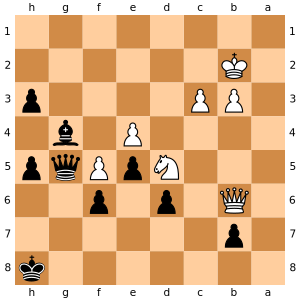

Error Chance: 0.76468956 Average Error Size: [0.75543255]


In [0]:
raw_fen = "7k/1p6/1Q1p1p2/3NpPqp/4P1b1/1PP4p/1K6/8 b - - 0 1"
display_board = chess.Board(raw_fen)
display(SVG(chess.svg.board(board=display_board, flipped=not display_board.turn, size=300))) # Displays the board

processed = process_fen(raw_fen)
example_input = flat_input(processed)
example_input = np.reshape(example_input, (1, 769))

classification_prediction = classification_network.model.predict(example_input)
regression_prediction = regression_network.model.predict(example_input)

print("Error Chance:", classification_prediction[0][1], "Average Error Size:", regression_prediction[0])

Part II - Suggest Positions

Process PGN

In [0]:
def process_fen(unprocessed_fen): # Remove the move tags
  split = unprocessed_fen.split(" ")
  new_fen = unprocessed_fen
  if len(split) == 6:
    new_fen = ""
    for i in range(len(split) - 2):
      new_fen = new_fen + split[i] + " "
  
  return new_fen

def reset_pgn():
  return open("/content/drive/My Drive/Chess/WorldCup.pgn")

def process_pgn(pgn, total_positions, cutoff, reference_list):
  # Input: Reference_List - dictionary of positions already visited
  # Cutoff: What move to start adding positions (to remove opening theory)
  # Total_games: how many games to process
  # Pgn: What pgn to process
  # Returns Output_list - list of new positions from processing games 
  counter = 0 # To mantain unique positions, only take every 9th half-move
  output_list = []

  while len(output_list) < total_positions:
    first_game = chess.pgn.read_game(pgn)
    board = first_game.board()

    for move in first_game.mainline_moves():
      if board.fullmove_number > cutoff and not board.is_game_over() and counter % 9 == 0: # Save if not opening theory
        fen_position = process_fen(board.fen()) 
        if fen_position not in reference_list and fen_position not in output_list:
          output_list.append(fen_position)
        
      board.push(move) # Make a move
      counter = counter + 1

  # random.shuffle(output_list) # Shuffle the list
  return output_list

# Input -> MLP Network, List of FENs -> Returns a list of the [hardest problems] and [all difficulties]
def rank_sort(mlp_class, mlp_regress, fen_list):
  difficulties = np.zeros((len(fen_list)))
  
  for i in range(len(fen_list)):
    example_input = flat_input(fen_list[i])
    example_input = np.reshape(example_input, (1, 769))
    classification_prediction = mlp_class.model.predict(example_input)
    regression_prediction = mlp_regress.model.predict(example_input)

    difficulties[i] = classification_prediction[0][1] * regression_prediction[0]

  top_ten = np.argsort(difficulties)
  return top_ten, difficulties

Results - Searching through World Cup Positions

Difficulty [0.30060768 0.39890492 0.27311629 ... 0.14400165 0.15373942 0.23642874]
Hardest [903 174 642 145 395 904 912 108 913 175]

FEN 8/1p1r4/p4qk1/P2pRp2/3P1Pp1/3Q4/5PK1/8 w - - 
Error Chance: 0.698 Amount: 0.896 Difficulty 0.625


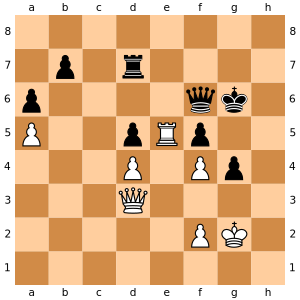

Side to Move: White

FEN r4r1k/pb2Npbp/4pnp1/1NQ5/2B5/2P3P1/PP3P1q/2KRR3 w - - 
Error Chance: 0.736 Amount: 0.852 Difficulty 0.628


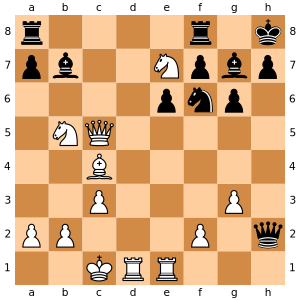

Side to Move: White

FEN 4r3/4r2k/P1p4p/1pNb4/3Qpq2/P4p1P/1R6/5BRK w - - 
Error Chance: 0.924 Amount: 0.688 Difficulty 0.636


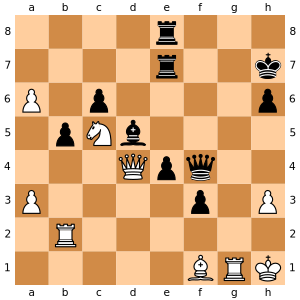

Side to Move: White

FEN 7r/3R1p2/2P2pkp/5N1R/4pbPP/1Pr5/5PK1/8 b - - 
Error Chance: 0.749 Amount: 0.85 Difficulty 0.636


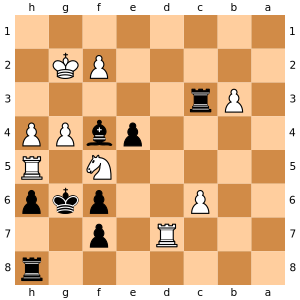

Side to Move: Black

FEN 5k2/5B2/5bP1/1K6/1P2R3/8/8/1r6 b - - 
Error Chance: 0.692 Amount: 0.927 Difficulty 0.641


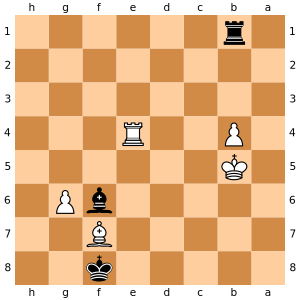

Side to Move: Black

FEN 3qR3/1p6/p2r2k1/P1Qp1p2/3P1Pp1/8/5PK1/8 b - - 
Error Chance: 0.683 Amount: 0.939 Difficulty 0.642


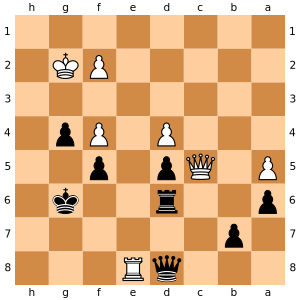

Side to Move: Black

FEN 4k3/2Q5/7q/p2KP3/3P2p1/8/5P2/8 b - - 
Error Chance: 0.721 Amount: 0.892 Difficulty 0.643


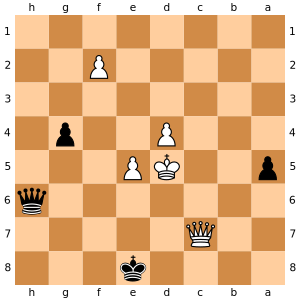

Side to Move: Black

FEN 3r1bk1/pp3r1q/5Nnp/P1pP4/2N2pp1/6Pb/1B2Q2P/3RR1K1 b - - 
Error Chance: 0.78 Amount: 0.853 Difficulty 0.665


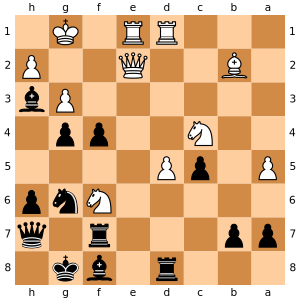

Side to Move: Black

FEN 4k3/2Q5/2K1P3/p2P4/2q3p1/8/5P2/8 w - - 
Error Chance: 0.677 Amount: 1.017 Difficulty 0.689


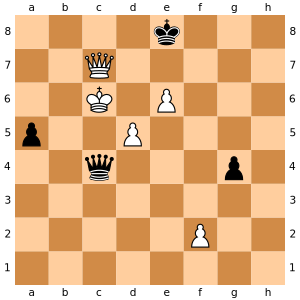

Side to Move: White

FEN r4r1k/p3NN1p/2Q1p1pb/8/4n3/2P2bP1/PPK1Bq2/3RR3 b - - 
Error Chance: 0.861 Amount: 0.806 Difficulty 0.694


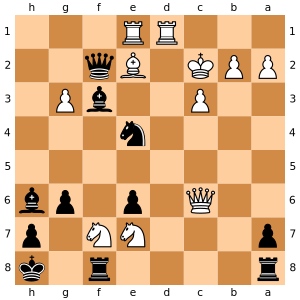

Side to Move: Black


In [0]:
global_fen_list = []

number_positions = 1000
move_cutoff = 11 # Start at move 12
# pgn_world = reset_pgn()
# fen_list = process_pgn(pgn_world, number_positions, move_cutoff, global_fen_list)
# sorted_indices, all_difficulties = rank_sort(classification_network, regression_network, fen_list)

hardest_ten_index = sorted_indices[990:1000]

print("Difficulty", all_difficulties)
print("Hardest", hardest_ten_index)

for i in range(10):
  # print("\nNumber ", i, "/10")
  fen = fen_list[hardest_ten_index[i]]
  fen_input = flat_input(fen)
  fen_input = np.reshape(fen_input, (1, 769))
  print("\nFEN", fen)
  print("Error Chance:", round(classification_network.model.predict(fen_input)[0][1], 3), "Amount:", round(regression_network.model.predict(fen_input)[0][0], 3), "Difficulty", round(all_difficulties[hardest_ten_index[i]], 3))
  board = chess.Board(fen_list[hardest_ten_index[i]])
  display(SVG(chess.svg.board(board=board, flipped=not board.turn, size=300))) # Displays the board
  print("Side to Move:", "White" if board.turn else "Black")
  # print("Castling White K/Q:", board.has_kingside_castling_rights(True), board.has_queenside_castling_rights(True))
  # print("Castling Black K/Q:", board.has_kingside_castling_rights(False), board.has_queenside_castling_rights(False))
  # print("En Passant:", "None" if board.ep_square == None else chess.SQUARE_NAMES[board.ep_square])

Mean: 0.2932208498378476 Standard Deviation: 0.12772230367386253


(array([ 30., 116., 211., 223., 194., 123.,  65.,  25.,  11.,   4.]),
 array([0.01167152, 0.08647902, 0.16128651, 0.23609401, 0.31090151,
        0.38570901, 0.4605165 , 0.535324  , 0.6101315 , 0.68493899,
        0.75974649]),
 <a list of 10 Patch objects>)

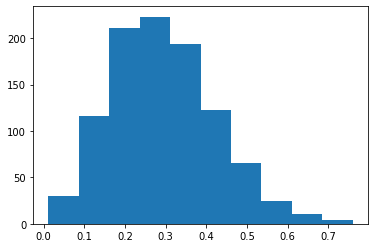

In [0]:
import matplotlib.pyplot as plt
print("Mean:", np.mean(all_difficulties), "Standard Deviation:", np.std(all_difficulties))
plt.hist(all_difficulties)